## Dog and Cat classification using Transfer Learning wit Resnet50

In the last notebook, I have created a model with my own configuration in model's layers which you can refer in this [link](http://bit.ly/30lp47O). Although 87.8% accruacy from my model seems pretty well but I have found some models achieved 98% accuracy in Kaggle competition. For this reason, I would like to use Transfer Learning with Resnet50 to see whether I can imporve the accuracy. 

**Transfer learning** is a machine learning method where a model developed for a task is resued for another task. **Resnet50** is a convolutional neural network that is trained on more than a million images from the Imagenetdatabase. I had used 12 layers in my last model, yet the pre-train model of **Restnet50** contains 50 layers deep and can classifiy images into 1000 object categories. It should be notice that the image input size for **Resnet50** is 224x224, thus the input dataset need to be converted into this image standard size. 

Depend on the size (big/small) and property (similar/different) of the dataset compared to the dataset that Resnet50 was trained (Imagenet), we have different strategies to train our model which you can refer to this [link](http://bit.ly/2nu8XqY). Since my dataset (25,000 images) can be considered **small & similar** compared to imagenet dataset (14 million images including millions of dog and cat pictures), I will just remove the last classifed layer (layers with 1000 classes), run the pre-trained model to extract features, and then use the resulting features to train new classifier. 

#### Warning:
Training with Resnet50 pretrain-model might be disturbing if your computers do not have GPU or have a low configuration. Fortunately, you can use **Google Colab** to train your model with Google Sever and save it in google drive. The server has GPU, is fast and more important, free!

### Visualizing the Data

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

%matplotlib inline

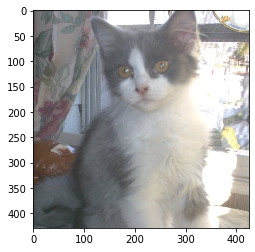

In [2]:
# Show a random images from CAT category 

rand = np.random.randint(0,9373)


cat_rand=cv2.imread("CATS_DOGS/train/CAT/{}.jpg".format(str(rand)))
cat_rand=cv2.cvtColor(cat_rand,cv2.COLOR_BGR2RGB)
plt.imshow(cat_rand)

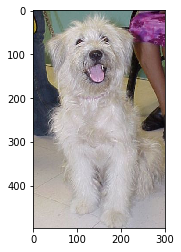

In [3]:
# Show a random images from CAT category 

dog_rand=cv2.imread("CATS_DOGS/train/DOG/{}.jpg".format(str(rand)))
dog_rand=cv2.cvtColor(dog_rand,cv2.COLOR_BGR2RGB)
plt.imshow(dog_rand)

### Data augmentation

In [3]:
from keras.preprocessing.image import ImageDataGenerator, load_img
"""
rotation_range=30: randomly rotate image angle from 0 to 30 degree
width_shift_range=0.1: randomly stretch the image along x_axis from 0 to 10%
height_shift_range=0.1: randomly stretch the image along y_axis from 0 to 10%
rescale=1/255: rescale image to the range from 0 to 1
shear_range=0.2: randomly crop the image from 0 to 20%
zoom_range=0.2: randomly zoom the image from 0 to 20%
horizontal_flip=True: randomly flip the image in horizontal direction
fill_mode="nearest": During the random image processing, we will fill in the mixing pixels with the nearset ones if they are missing 
"""
image_gen = ImageDataGenerator(rotation_range=30,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              rescale=1/255,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              fill_mode="nearest")

Using TensorFlow backend.


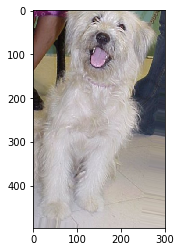

In [5]:
plt.imshow(image_gen.random_transform(dog_rand))

In [4]:
image_gen.flow_from_directory("CATS_DOGS/train")

Found 18743 images belonging to 2 classes.


In [7]:
input_shape = (224,224,3)

### Cread a new model, add and configure pre-trained layers of Resnet50

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import ModelCheckpoint

In [6]:
from keras.applications.resnet50 import ResNet50
from keras.layers import Input

resnet_model = ResNet50(weights='imagenet',include_top=True)


Instructions for updating:
Colocations handled automatically by placer.


In [7]:
resnet_model.layers.pop() # Remove the last classified layer
resnet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [8]:
model_resnet50 = Sequential()


In [9]:
model_resnet50.add(Dense(3, input_shape=(224,224,3),activation='relu'))

model_resnet50.add(resnet_model)

model_resnet50.add(Dense(2, activation='softmax'))

model_resnet50.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model_resnet50.summary()

# Save the best weigth during training

filepath="weights_best.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,save_weights_only=True, mode='max')

callbacks_list = [checkpoint]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 224, 224, 3)       12        
_________________________________________________________________
resnet50 (Model)             (None, 1000)              23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2002      
Total params: 23,589,726
Trainable params: 23,536,606
Non-trainable params: 53,120
_________________________________________________________________


### Prepare training data

In [10]:
input_shape=(224,224,3)

batch_size = 16

train_image_gen = image_gen.flow_from_directory("CATS_DOGS/train/",
                                                target_size=input_shape[:2],
                                                batch_size=batch_size,
                                                class_mode="categorical")

valid_image_gen = image_gen.flow_from_directory("CATS_DOGS/test/",
                                                target_size=input_shape[:2],
                                                batch_size=batch_size,
                                                class_mode="categorical")

test_image_gen = image_gen.flow_from_directory("CATS_DOGS/test_set/",
                                              target_size=input_shape[:2],
                                              batch_size=batch_size,
                                              class_mode="categorical")


Found 18743 images belonging to 2 classes.
Found 6251 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


### Let train our model

In [0]:
results_resnet50=model_resnet50.fit_generator(train_image_gen,epochs=20,steps_per_epoch=len(train_image_gen),
                           validation_data=valid_image_gen,validation_steps=len(valid_image_gen),callbacks=callbacks_list,verbose=2)

Epoch 1/20
 - 717s - loss: 0.1081 - acc: 0.9578 - val_loss: 0.1452 - val_acc: 0.9414
Epoch 2/20
 - 705s - loss: 0.1048 - acc: 0.9600 - val_loss: 0.2928 - val_acc: 0.9202
Epoch 3/20
 - 705s - loss: 0.1060 - acc: 0.9604 - val_loss: 0.1982 - val_acc: 0.9234
Epoch 4/20
 - 702s - loss: 0.1029 - acc: 0.9617 - val_loss: 0.1735 - val_acc: 0.9421
Epoch 5/20
 - 707s - loss: 0.1047 - acc: 0.9616 - val_loss: 0.1816 - val_acc: 0.9320
Epoch 6/20
 - 720s - loss: 0.1035 - acc: 0.9619 - val_loss: 3.3114 - val_acc: 0.5948
Epoch 7/20
 - 710s - loss: 0.0995 - acc: 0.9638 - val_loss: 0.3564 - val_acc: 0.9160
Epoch 8/20
 - 704s - loss: 0.0997 - acc: 0.9622 - val_loss: 1.7836 - val_acc: 0.8163
Epoch 9/20
 - 706s - loss: 0.0942 - acc: 0.9645 - val_loss: 0.3340 - val_acc: 0.8845
Epoch 10/20
 - 704s - loss: 0.0942 - acc: 0.9632 - val_loss: 0.2957 - val_acc: 0.8856
Epoch 11/20
 - 704s - loss: 0.0986 - acc: 0.9641 - val_loss: 0.2749 - val_acc: 0.8912
Epoch 12/20
 - 706s - loss: 0.0908 - acc: 0.9662 - val_loss: 0.

#### In here you should notice that I use "callbacks" to tell my model save only the best weight. As you can see, the model achived best accuracy in epoch 16 and this weight will be saved in the next step

In [21]:
model_resnet50.save_weights("Resnet50.h5")

In [11]:
model_resnet50.load_weights("Resnet50.h5")

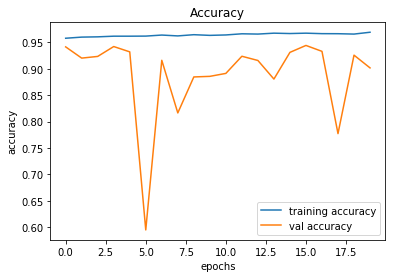

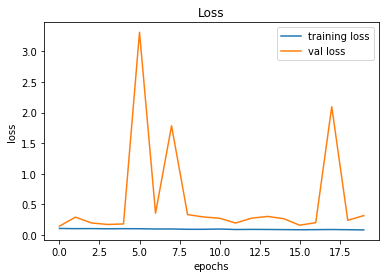

In [0]:
plt.figure(0)
plt.plot(results_resnet50.history['acc'], label='training accuracy')
plt.plot(results_resnet50.history['val_acc'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(results_resnet50.history['loss'], label='training loss')
plt.plot(results_resnet50.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Test our model with complete new data of dog and cat

To evaluate the model, I will test the model with completely new dataset which the model hasn't never seen before so we can remove any bias factor. The testing dataset can be downloaded from kaggle in this [link](https://www.kaggle.com/tongpython/cat-and-dog/downloads/cat-and-dog.zip/1).

In [12]:
pred = model_resnet50.predict_generator(test_image_gen,steps=len(test_image_gen),verbose=1)

127/127 [==============================] - 673s 5s/step


In [13]:
loss, acc = model_resnet50.evaluate_generator(test_image_gen, steps=len(test_image_gen), verbose=0)

In [14]:
print("The accuracy of Resnet50_model is {}%".format(str(np.around(acc*100,2))))

The accuracy of Resnet50_model is 95.8%


### Visualizing the prediction of our model

**WOW 95.8% ACCURACY!** I was surprised that the accuracy is as that high. Transfer learning is obiviouly a powerful method for Machine Learning.  

As a person who hate to see just dry numbers, I will predict and illustrate the result from our model's prediction in the next step

In [27]:
import numpy as np

def show_result(test_image):
    test_image = cv2.imread("CATS_DOGS/test_random/test1/{}".format(test_image))
    test_image = cv2.resize(test_image,(224,224))
    test_image = test_image/255
    test_image = test_image.reshape(1,224,224,3)
    
    prediction = model_resnet50.predict_classes(test_image)
    prediction_prob = model_resnet50.predict(test_image)
    
    if prediction.max()==1:
        return "DOG"
    else:
        return "CAT"

In [28]:
import os
test_random = os.listdir("CATS_DOGS/test_random/test1/")
len(test_random)

12500

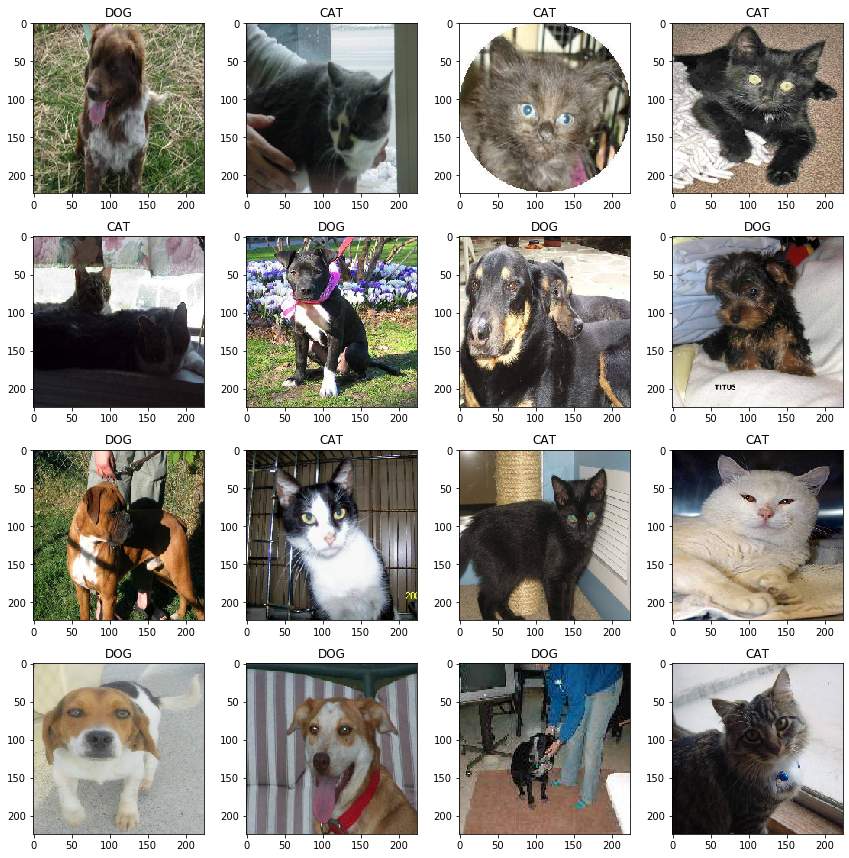

In [35]:
fig=plt.figure(figsize=(12, 12))
columns = 4
rows = 4
fig_list= []

for i in range(1, columns*rows +1):
    rand = np.random.randint(12500)
    fig_list.append(fig.add_subplot(rows, columns, i))
    fig_list[-1].set_title(show_result(test_random[rand]))
    img = load_img("CATS_DOGS/test_random/test1/{}".format(test_random[rand]),target_size=(224,224))
    plt.imshow(img)
    
plt.tight_layout(True)   
plt.show()

## Conclusion
- Using pre-train model of Resnet50 on Imagenet dataset, my model achieved a much better accuracy than the last one (95% accuracy). 
- Transfer learning is such a powerful tool since it help us to imporve our model's performance as well as reduce the model-developed time. *"I was shocked as soon as I did it (transfer learning with NLP), the basic prototype took a couple of days smashed the state-of-the-art on one of the most important datasets in a field that I knew nothing about. This is ridiculous!"* - said Jeremy Howard about Transfer Learning [[source](https://www.youtube.com/watch?v=Bi7f1JSSlh8)]
- Neverthelss, transfer learning can be computationally expensive and require time to tune and train the model. In my case it tooks 3 days struggling on Google Colab server.  

# The End!